In [1]:
!pip install datatrove openai
!pip install rank-bm25

In [2]:
HYPERBOLIC_API_KEY = "~"


In [3]:
import re
import json
import pickle
import tqdm.auto as tqdm
import pandas as pd
import openai
from typing import List
from datatrove.pipeline.readers import ParquetReader
openai.api_key = HYPERBOLIC_API_KEY

In [4]:
# Question Generation

def generate_questions(prompt: str, model: str = "meta-llama/Meta-Llama-3.1-8B-Instruct", max_tokens: int = 256):
    client = openai.OpenAI(
        base_url = "https://api.hyperbolic.xyz/v1",
        api_key = HYPERBOLIC_API_KEY,
    )

    chat_completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are a question generation assistant."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.64,
    max_tokens=1024,
    )

    response = chat_completion.choices[0].message.content
    return response
    #questions = generated_text.split("\n")
    #return [q.strip() for q in questions if q.strip()]

def input_prompt(text: str, num_questions: int = 10) -> str:
    instruction = f"""
    Generate {num_questions} questions based on the following text. Do not include trivial questions.
    The answer should be formed in a JSON list like below.

    [
        {{"question": "Generated Question 1", "evidence": "The part of a text on which it is based"}},
        {{"question": "Generated Question 2", "evidence": "The part of a text on which it is based"}},
        ... ,
        {{"question": "Generated Question {num_questions}", "evidence": "The part of a text on which it is based"}},
    ]
    ----------------------
    """
    document = f"Text: {text}"
    prompt = f"{instruction}\n\n{document}"
    return prompt

def main():
    data_reader = ParquetReader("hf://datasets/HuggingFaceFW/fineweb/data", limit=5)
    docs = [document.text for document in data_reader()]

    prompts = [input_prompt(d) for d in docs]
    questions = [generate_questions(p) for p in tqdm.tqdm(prompts)]

    print("Generated questions:")
    for i, question in enumerate(questions, 1):
        print(f"{i}. {question}")

    with open('question_evidence.pickle', 'wb') as f:
        pickle.dump(questions, f, pickle.HIGHEST_PROTOCOL)
    with open('original_docs.pickle', 'wb') as f:
        pickle.dump(docs, f, pickle.HIGHEST_PROTOCOL)

if __name__ == "__main__":
    main()

2024-09-07 03:49:02.842 | INFO     | datatrove.pipeline.readers.base:read_files_shard:191 - Reading input file CC-MAIN-2013-20/000_00000.parquet, 1/23781


  0%|          | 0/5 [00:00<?, ?it/s]

Generated questions:
1. Here are 10 questions based on the given text in a JSON list:

[
  {"question": "What was the first serious bout of tornadoes in 2012 like?", "evidence": "When the first serious bout of tornadoes of 2012 blew through middle America in the middle of the night"},
  {"question": "How did Robert Ray decide to travel to Harrisburg, Ill.?", "evidence": "He never got on board a plane. Instead, he ended up driving toward Harrisburg, Ill."},
  {"question": "What was the first format in which Robert Ray reported on the tornadoes in Harrisburg, Ill.?", "evidence": "He shot powerful video, put victims on the phone with AP Radio and played back sound to an editor who transcribed the interviews and put the material on text wires"},
  {"question": "What was the name of the young girl who found a man's prosthetic leg in the rubble?", "evidence": "Ray also made a dramatic image of a young girl who found a man’s prosthetic leg in the rubble"},
  {"question": "What was Robert Ray'

In [5]:
# question sampling
import pandas as pd

def extract_json(text):
    question_evidence_pair = '['+re.findall(r'\[(.*?)\]', text, re.S)[0]+']'
    return eval(question_evidence_pair)

with open('question_evidence.pickle', 'rb') as f:
    questions = pickle.load(f)

sampled_questions = [pd.DataFrame(extract_json(qs))['question'].sample() for qs in questions]
sampled_questions = pd.concat(sampled_questions).reset_index(drop=True).tolist()
sampled_questions

['What was the first serious bout of tornadoes in 2012 like?',
 "What is the role of adrenaline in the body's response to stress?",
 'What are the contact details for further information about the car wash event?',
 'Who offered hot air balloon rides to the community at the Missoula County Fairgrounds?',
 'What should a user do if they forgot their ECode?']

In [6]:
# question expansion

def expand_questions(prompt: str, model: str = "meta-llama/Meta-Llama-3.1-8B-Instruct", max_tokens: int = 256) -> List[str]:
    client = openai.OpenAI(
        base_url = "https://api.hyperbolic.xyz/v1",
        api_key = HYPERBOLIC_API_KEY,
    )

    chat_completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are a smart agent."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.72,
    max_tokens=1024,
    )

    response = chat_completion.choices[0].message.content
    return response

def input_prompt(text: str) -> str:
    instruction = f"""
    Answer according to the instructions below.

    1. Expert identification:
    Analyze the topic of the question, and think of the type of professional you need.

    2. Collect Expert Perspectives:
    Write down the answers to the questions from the perspective of each expert. Reflect on the expert's background and experience.

    3. Keyword Expansion:
    List key keywords with hashtags (#).

    4. Structuring the answer:
    Write a clear and comprehensive final answer by integrating expert opinions and keywords. You do not have to mention who the experts are. Just separate your answers.
    ----------------------
    """
    document = f"Question: {text}"
    prompt = f"{instruction}\n\n{document}"
    return prompt

def main():
    #questions = [
    #    "What is the main theme of Jian Ghomeshi's book 1982?",
    #    "How does adrenaline affect blood circulation in the body?"
    #]
    questions = sampled_questions
    prompts = [input_prompt(q) for q in questions]
    expansions = [expand_questions(p) for p in tqdm.tqdm(prompts)]

    print("Generated expansions:")
    for i, expansion in enumerate(expansions, 1):
        print("----------------------------")
        print(f"{i}. {expansion}")

    with open('expansions.pickle', 'wb') as f:
        pickle.dump(expansions, f, pickle.HIGHEST_PROTOCOL)

if __name__ == "__main__":
    main()

  0%|          | 0/5 [00:00<?, ?it/s]

Generated expansions:
----------------------------
1. **Expert Identification:**
To analyze the first serious bout of tornadoes in 2012, we need experts in the field of meteorology, particularly those who study severe weather patterns and tornado events.

**Collect Expert Perspectives:**

The first serious bout of tornadoes in 2012 occurred in late April, known as the 2012 Easter Tornado Outbreak. According to historical records, this event was part of a larger severe weather outbreak that affected several states in the United States.

- **Weather Pattern:** The event was characterized by a strong low-pressure system that moved across the Great Plains, creating a conducive environment for severe thunderstorms and tornadoes to develop.
- **Tornado Activity:** The outbreak produced a significant number of tornadoes, with the majority being classified as EF2 or EF3. At least 38 tornadoes were reported across six states, resulting in significant damage and loss of life.
- **Impact:** The 2

In [7]:
def extract_json(text):
    question_evidence_pair = '['+re.findall(r'\[(.*?)\]', text, re.S)[0]+']'
    return eval(question_evidence_pair)

with open('question_evidence.pickle', 'rb') as f:
    questions = pickle.load(f)

questions = [pd.DataFrame(extract_json(qs))['question'] for qs in questions]
questions = pd.concat(questions).reset_index(drop=True)

In [8]:
with open('expansions.pickle', 'rb') as f:
    expansions = pickle.load(f)

In [9]:
with open('original_docs.pickle', 'rb') as f:
    docs = pickle.load(f)

In [10]:
import matplotlib.pyplot as plt
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

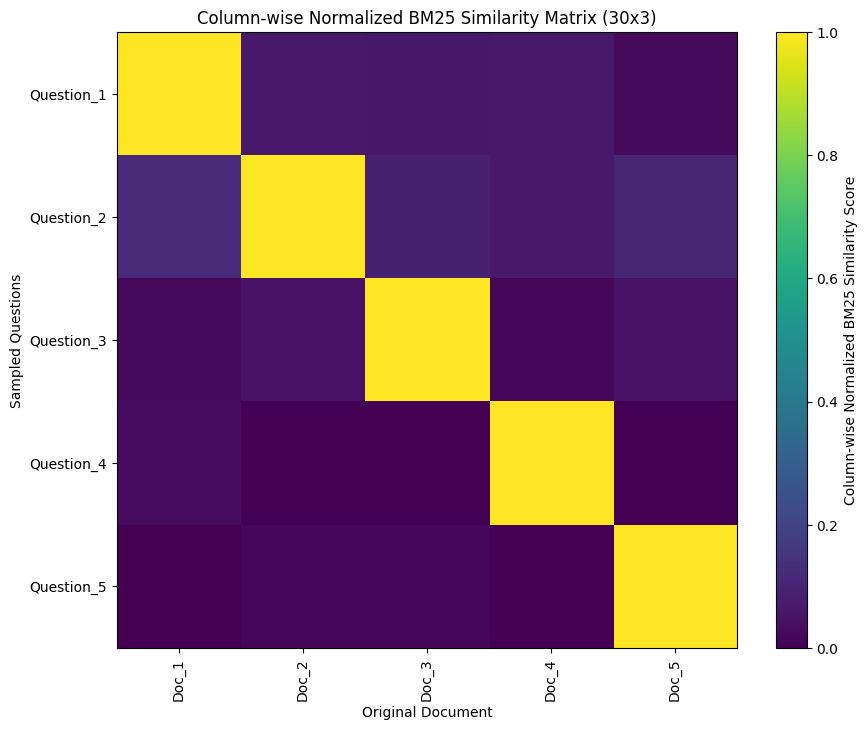

In [11]:
##bm25 similarity

#texts_set_1 = sampled_questions
texts_set_1 = expansions
texts_set_2 = docs

# Tokenize
def tokenize(texts):
    vectorizer = CountVectorizer().build_analyzer()
    return [vectorizer(text) for text in texts]

tokenized_set_1 = tokenize(texts_set_1)
tokenized_set_2 = tokenize(texts_set_2)

# BM25 Object
bm25 = BM25Okapi(tokenized_set_2)

# Similarity Matrix
similarity_matrix = []

for doc_tokens in tokenized_set_2:
    scores = bm25.get_scores(doc_tokens)
    similarity_matrix.append(scores)

df_similarity = pd.DataFrame(similarity_matrix).T
df_similarity.columns = [f"Doc_{i+1}" for i in range(len(texts_set_2))]
df_similarity.index = [f"Question_{i+1}" for i in range(len(texts_set_1))]

# column-wise Normalization
scaler = MinMaxScaler()
df_similarity_normalized = df_similarity.copy()

for column in df_similarity.columns:
    df_similarity_normalized[column] = scaler.fit_transform(df_similarity[[column]])

# Normalized Similarity Matrix
plt.figure(figsize=(10, 8))
plt.imshow(df_similarity_normalized, aspect='auto', cmap='viridis')
plt.colorbar(label='Column-wise Normalized BM25 Similarity Score')
plt.xticks(range(len(df_similarity_normalized.columns)), df_similarity_normalized.columns, rotation=90)
plt.yticks(range(len(df_similarity_normalized.index)), df_similarity_normalized.index)
plt.title('Column-wise Normalized BM25 Similarity Matrix (30x3)')
plt.xlabel('Original Document')
plt.ylabel('Sampled Questions')
plt.show()